1. PROJECT TITLE- SHOPPER SPECTRUM: CUSTOMER SEGMENTATION AND PRODUCT RECOMMENDATIONS IN E-COMMERCE.

2. PROJECT SUMMARY-

    This project analyzes online retail transaction data to understand customer purchasing behavior and improve business decision-making. Customers are segmented using Recency, Frequency, and Monetary (RFM) analysis with KMeans clustering to identify groups such as High-Value, Regular, Occasional, and At-Risk customers. In addition, an item-based collaborative filtering recommendation system is built using cosine similarity to suggest relevant products based on past purchase patterns. The final solution is deployed through an interactive Streamlit application that provides real-time customer segmentation and personalized product recommendations.

3. PROBLEM STATEMENT- 

    The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth.

    This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.

4. DATA WRANGLING-

In [ ]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Creating the dataframe
df = pd.read_csv('../data/online_retail.csv')

# To prevent truncating
pd.set_option('display.max_columns', None)

# Checking the first few rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-22 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-22 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-22 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-22 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-22 08:26,3.39,17850.0,United Kingdom


In [4]:
# Checking the shape of the dataframe
df.shape

(541909, 8)

In [5]:
# Checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Checking the description of the dataframe
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# Checking the null values in the dataframe
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Checking the duplicate rows in the dataframe
df.duplicated().sum()

np.int64(5268)

In [ ]:
# Defining a function that will help clean the dataframe
def df_cleaner(df):
    df = df.copy()
    # Removing the null values from CustomerID column
    df = df.dropna(subset=['CustomerID'])

    # Converting the CustomerID column to integer type for data consistency
    df['CustomerID'] = df['CustomerID'].astype(int)

    # Removing the duplicate rows from the dataframe
    df.drop_duplicates(inplace=True)

    # Removing the rows with negative UnitPrice from the dataframe
    df = df[df['UnitPrice'] > 0]

    # Removing the rows with negative quantities from the dataframe
    df = df[df['Quantity'] > 0]

    # Making sure the column of InvoiceNo is of string type
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)

    # Removing the rows of cancelled invoices (start with 'C') from the dataframe
    df = df[~df['InvoiceNo'].str.startswith('C')]

    # Converting the InvoiceDate column to datetime type
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])               #YYYY-MM-DD

    return df

In [10]:
# Storing the cleaned dataframe
df = df_cleaner(df)

In [11]:
# Checking the shape of the cleaned dataframe
df.shape

(392692, 8)

In [12]:
# Rechecking for null values in the cleaned dataframe
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
# Rechecking the cleaned dataframe for any duplicates
df.duplicated().sum()

np.int64(0)

In [14]:
# Checking the cleaned dataframe for any rows with cancelled invoices
df[df['InvoiceNo'].str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


5. Recency, Frequency and Monetary feature engineering.

In [15]:
# First we create a column of Total Amount by multiplying Quantity and UnitPrice. We will later use this for monetary calculation.
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [16]:
# Now, we define the global reference date for recency calculation
reference_date = df['InvoiceDate'].max()

In [17]:
# Calculating recency
recency_df = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x:(reference_date - x).days).reset_index()

In [18]:
# Renaming the columns in recency_df
recency_df.columns = ['CustomerID', 'Recency']

In [19]:
# Calculating frequency
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

In [20]:
# Renaming the columns in frequency_df
frequency_df.columns = ['CustomerID', 'Frequency']

In [21]:
# Calculating monetary
monetary_df = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()

In [22]:
# Renaming the columns in monetary_df
monetary_df.columns = ['CustomerID', 'Monetary']

In [23]:
# Creating a new dataframe by merging recency, frequency and monetary dataframes
rfm = recency_df.merge(frequency_df, on='CustomerID')
rfm = rfm.merge(monetary_df, on='CustomerID')

In [24]:
# Checking few rows of the rfm dataframe
rfm.sample(7)

,CustomerID,Recency,Frequency,Monetary
2527,15785,152,5,2328.97
522,13030,12,2,752.44
582,13115,0,4,2294.78
4007,17837,30,8,1541.23
3517,17153,25,1,213.78
1972,15048,117,4,381.00
520,13028,23,2,661.32


In [25]:
# Checking the shape of the rfm dataframe
rfm.shape

(4338, 4)

In [26]:
# Checking the description of the rfm dataframe
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,105.470954,4.272015,2048.688081
std,1721.808492,115.082161,7.697998,8985.230220
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,22.000000,1.000000,306.482500
50%,15299.500000,61.000000,2.000000,668.570000
75%,16778.750000,161.750000,5.000000,1660.597500
max,18287.000000,697.000000,209.000000,280206.020000


6. Exploratory Data Analysis.

I. Visualising the transaction volume by country.

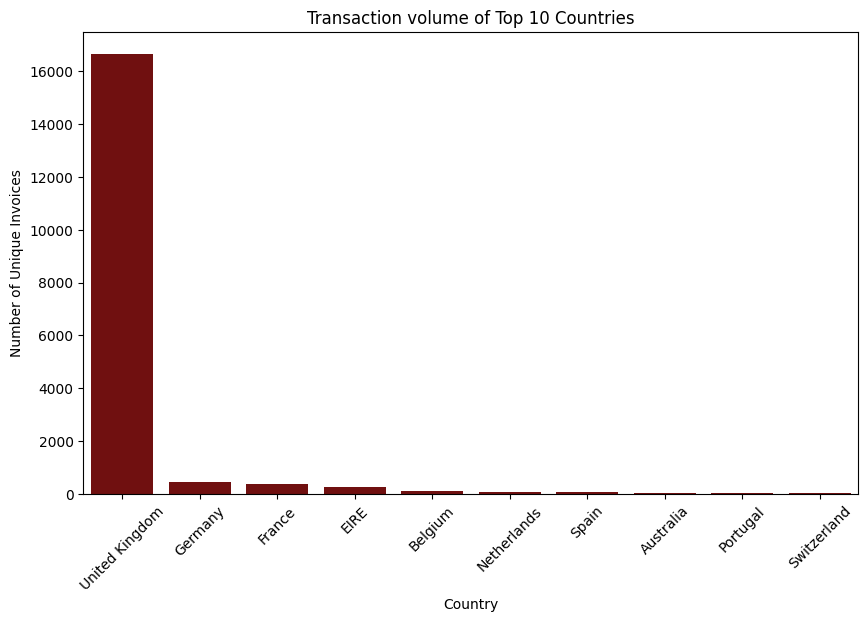

In [27]:
# Creating a dataframe that will contain the count of unique invoice numbers for the top 10 countries
top_countries = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).reset_index()
top_countries.columns = ['Country', 'UniqueInvoiceCount']

# Plotting the graph
plt.figure(figsize=(10,6))
sns.barplot(data=top_countries, x='Country', y='UniqueInvoiceCount', color='maroon')
plt.title('Transaction volume of Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Unique Invoices')
plt.xticks(rotation=45)
plt.show()

Insights-
- From the graph above, we can clearly see that the dataset is dominated by the transactions from the United Kingdom.
- This clearly shows that the business primarily operates in the UK market, while other countries show very less contributions.

II. Visualising the top selling products.

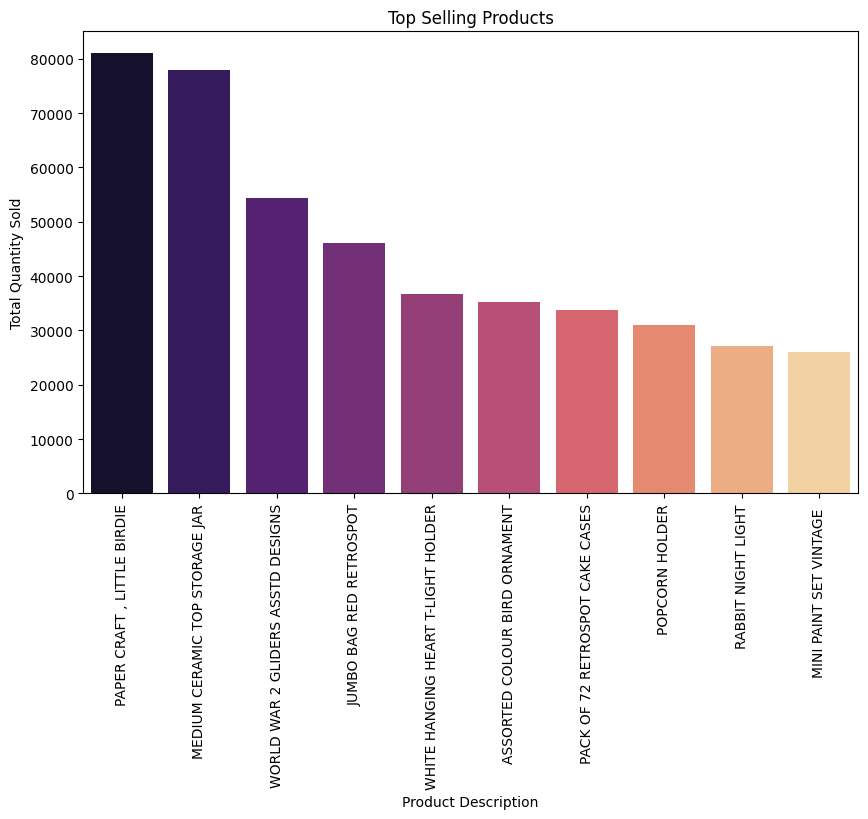

In [28]:
# Creating a dataframe that contains the data for the top selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
top_products.columns = ['Description', 'TotalQuantity']

# Plotting the graph
plt.figure(figsize=(10,6))
sns.barplot(data=top_products, x='Description', y='TotalQuantity', palette='magma')
plt.title('Top Selling Products')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()

Insights-
- From the above graph, we can see that the top selling products mostly comprise of gift-oriented and decorative items.
- So, these items are ideal candidates for inventory prioritisation.

III. Visualising purchase trends over time.

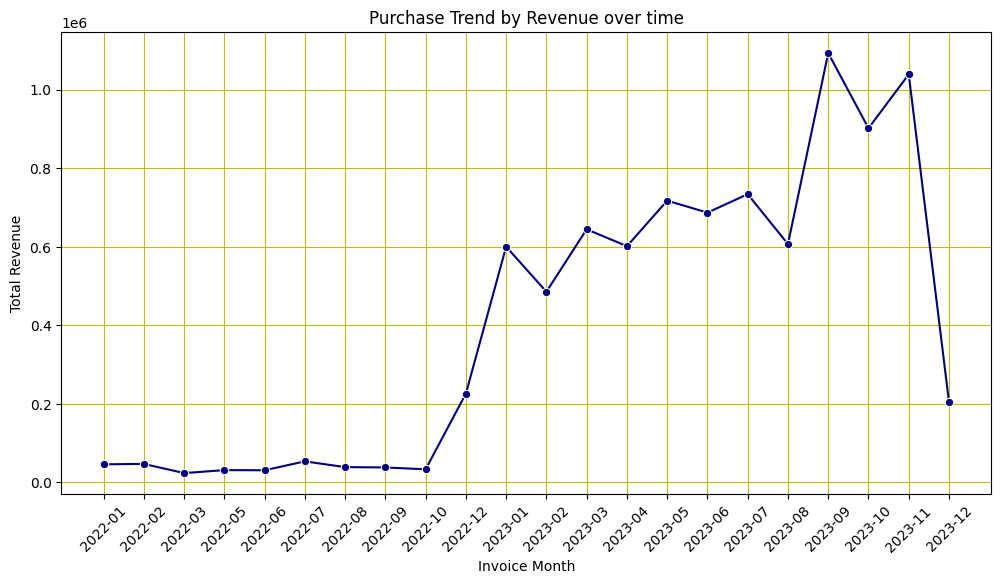

In [29]:
# Creating a column for Invoice Month
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Converting the InvoiceMonth column to string type
df['InvoiceMonth'] = df['InvoiceMonth'].astype(str)

# Creating a dataframe that contains the monthly revenue
MonthlyRevenue = df.groupby('InvoiceMonth')['TotalAmount'].sum().reset_index()

# Plotting the graph
plt.figure(figsize=(12,6))
sns.lineplot(data=MonthlyRevenue, x='InvoiceMonth', y='TotalAmount', marker='o', color='navy')
plt.xticks(rotation=45)
plt.grid(color='y')
plt.title('Purchase Trend by Revenue over time')
plt.xlabel('Invoice Month')
plt.ylabel('Total Revenue')
plt.show()

Insights-
- For the most part of the year 2022, the sales were relatively low and steady, not showing any huge change.
- From December-2022 to November-2023, the e-Commerce platform saw a rapid increase in sales, and then again decreasing in December-2023.

IV. Inspecting Monetary Distribution per Transaction.

Skewness of Transaction Values: 62.15354783703666
Kurtosis of Transaction Values: 5692.609083994739


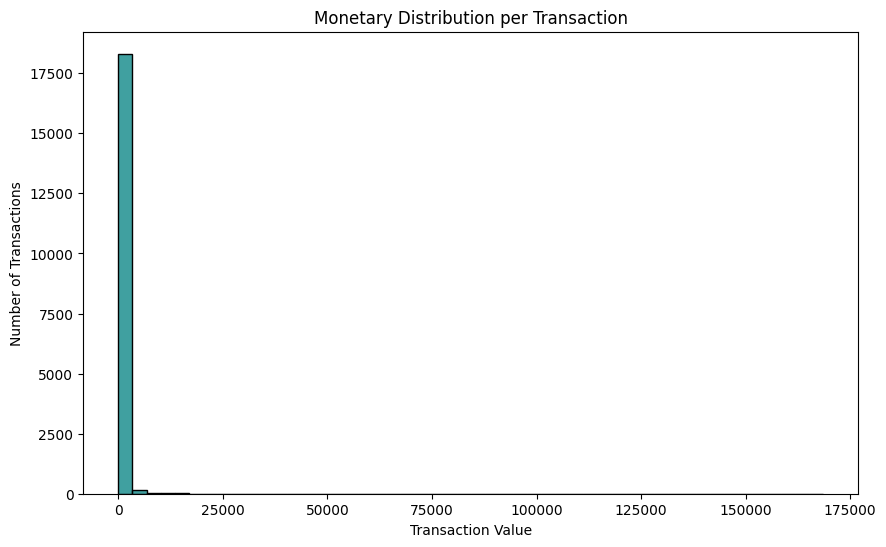

In [30]:
# Creating a dataframe that contains transaction value per invoice
invoice_values = df.groupby('InvoiceNo')['TotalAmount'].sum().reset_index()
invoice_values.columns = ['InvoiceNo', 'TransactionValue']

# Calculating skewness and kurtosis
skewness_tv = invoice_values['TransactionValue'].skew()
kurtosis_tv = invoice_values['TransactionValue'].kurtosis()
print(f'Skewness of Transaction Values: {skewness_tv}')
print(f'Kurtosis of Transaction Values: {kurtosis_tv}')

# Plotting the graph
plt.figure(figsize=(10,6))
sns.histplot(data=invoice_values, x='TransactionValue', bins=50, color='teal')
plt.title('Monetary Distribution per Transaction')
plt.xlabel('Transaction Value')
plt.ylabel('Number of Transactions')
plt.show()

Insights-
- We see that, from the graph and from the values of skewness and kurtosis, the data is strongly right skewed and is leptokurtic.
- This denotes that there exists a large number of smaller transactions and very few large transactions.
- This also shows that the e-Commerce platform caters mostly to B2C (Business to Customer) as compared to B2B (Business to Business).

V. Inspecting Monetary Distribution per Customer.

Skewness of Monetary Values: 19.339367981525182
Kurtosis of Monetary Values: 478.68428853545845


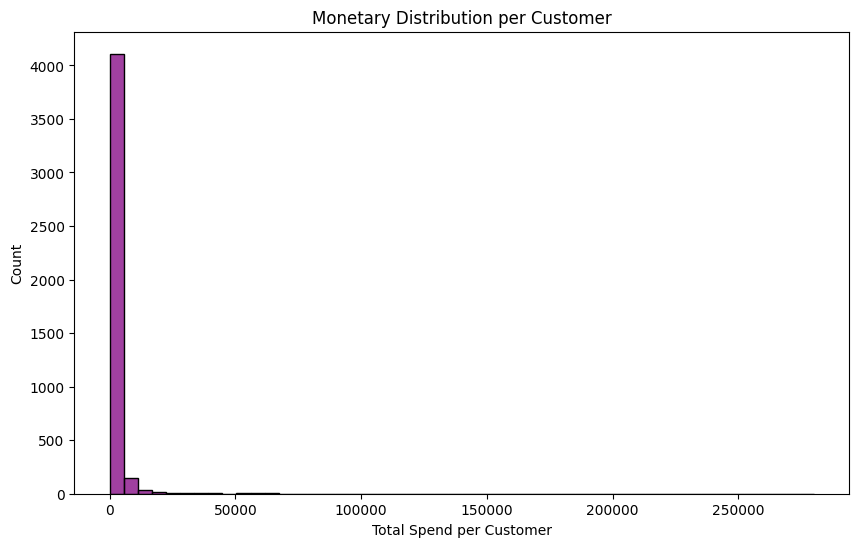

In [31]:
# Calculating skewness and kurtosis
skewness = rfm['Monetary'].skew()
kurtosis = rfm['Monetary'].kurtosis()
print(f'Skewness of Monetary Values: {skewness}')
print(f'Kurtosis of Monetary Values: {kurtosis}')

# Plotting the graph
plt.figure(figsize=(10,6))
sns.histplot(rfm['Monetary'], bins=50, color='purple')
plt.title('Monetary Distribution per Customer')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Count')
plt.show()

Insights-
- We see that, from the graph and from the values of skewness and kurtosis, the data is strongly right skewed and is leptokurtic.
- Most customers contribute to smaller transactions, while only a very small group of customers contribute to higher expenditures.

VI. Visualising the distribution of Recency.

Skewness of Recency Values: 1.9167154984371013
Kurtosis of Recency Values: 5.090268907497183


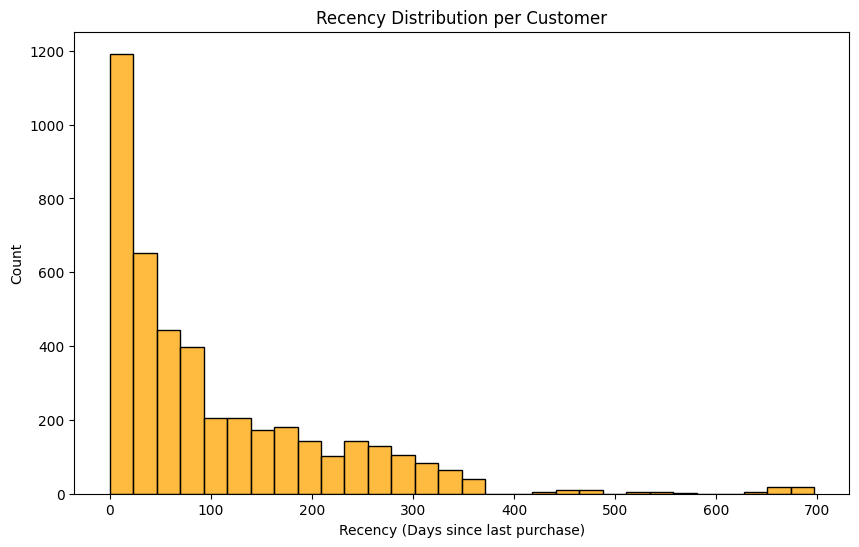

In [32]:
# Calculating the skewness and kurtosis
skewness_recency = rfm['Recency'].skew()
kurtosis_recency = rfm['Recency'].kurtosis()
print(f'Skewness of Recency Values: {skewness_recency}')
print(f'Kurtosis of Recency Values: {kurtosis_recency}')

# Plotting the graph
plt.figure(figsize=(10,6))
sns.histplot(rfm['Recency'], bins=30, color='orange')
plt.title('Recency Distribution per Customer')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Count')
plt.show()

Insights-
- Most customers have purchased recently, while a long tail represents customers who have been inactive for a long time.
- These inactive customers should be prioritised for re-engagement strategies.

VII. Visualising the Distribution of Frequency.

Skewness of Frequency Values: 12.067030826322075
Kurtosis of Frequency Values: 249.05812320006066


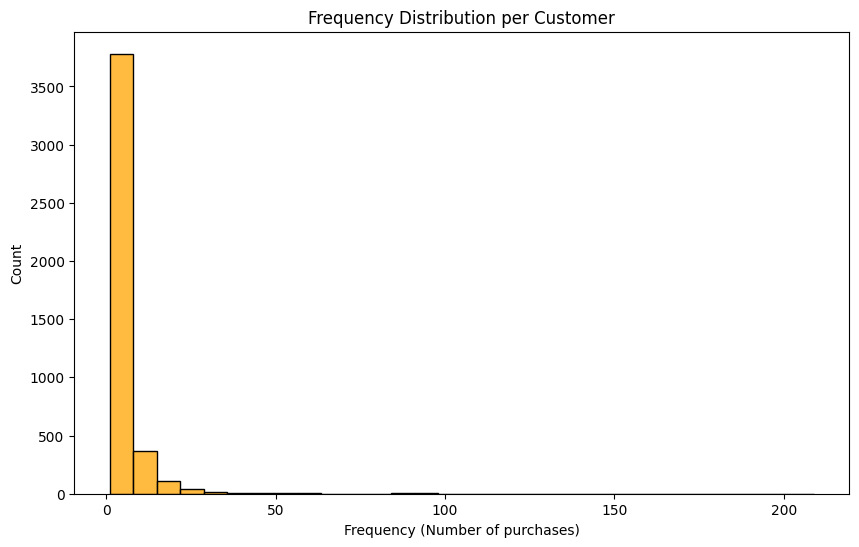

In [34]:
# Calculating the skewness and kurtosis
skewness_frequency = rfm['Frequency'].skew()
kurtosis_frequency = rfm['Frequency'].kurtosis()
print(f'Skewness of Frequency Values: {skewness_frequency}')
print(f'Kurtosis of Frequency Values: {kurtosis_frequency}')

# Plotting the graph
plt.figure(figsize=(10,6))
sns.histplot(rfm['Frequency'], bins=30, color='orange')
plt.title('Frequency Distribution per Customer')
plt.xlabel('Frequency (Number of purchases)')
plt.ylabel('Count')
plt.show()

Insights-
- The frequency distribution is heavily right-skewed. This shows that most customers do not make purchases very often.
- A very small group of customers make purchases regularly from this e-Commerce platform, highlighting the presence of a core group of loyal customers.

7. Saving the dataframes in CSV format.

In [35]:
df.to_csv('../data/cleaned_online_retail.csv', index=False)
rfm.to_csv('../data/rfm_features.csv', index=False)